<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/matt-sandbox/excitation-transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/matt-sandbox/excitation-transfer.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# Excitation transfer

This notebook is a first attempt at trying to observe an excitation transfer event using 2 two-state systems (we will also sometimes refer to them as particles) coupled to a field of harmonic oscillators

## Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np
import pandas as pd
from qutip import *
warnings.filterwarnings('ignore')

## Transforming the two-state Hamiltonian

We have previously looked at a two state system whose base states **|+>** and **|->** were represented as

$$
|+> = \begin{bmatrix}
 1   \\
 0   \\
 \end{bmatrix}, 
|-> = \begin{bmatrix}
 0   \\
 1   \\
\end{bmatrix}
$$


In [2]:
plus = basis(2, 0)
minus = basis(2, 1)

and whose energies $E_0$ were identical. When we considered that coupling between the states could occur (with strength $A$), the hamiltonian for the system could then be represented as

$$
H = \begin{bmatrix}
 E_0  &  -A  \\
 -A  &  E_0  \\
\end{bmatrix} = E_0 I - A \sigma_x
$$

In [3]:
# We will continue to use parameters from the first tutorial
E0 = 1.0
A = 0.1
H = E0*qeye(2) - A*sigmax()

Upon investigating the time evolution of states using the above Hamiltonian, we have seen that the stationary states of the system are not |+> and |->, but instead

$\frac{|+> + \,\  |->}{\sqrt{2}}$ - in phase (a.k.a symmetric) - lower energy state

$\frac{|+> - \,\  |->}{\sqrt{2}}$ - out of phase (a.k.a anti-symmetric) - higher energy state



In [4]:
in_phase = (plus + minus).unit()
out_phase = (plus - minus).unit()

It is often convenient to represent the system in terms of its stationary states, i.e. use the stationary states to form a new basis. Let's see what the Hamiltonian looks like when we do this.

In [5]:
H.transform([out_phase,in_phase])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1.1 0. ]
 [0.  0.9]]

As we can see, the transformed Hamiltonian can be represented as 

$$
H = \begin{bmatrix}
 E_0+A  &  0  \\
 0  &  E_0-A  \\
\end{bmatrix} = E_0 I + A \sigma_z
$$

Because it is only energy differences that can be physically measured, $E_0$ is often set to zero for convenience. We will follow this convention for the rest of this notebook. Our two state Hamiltonian is then:

$$
H = \begin{bmatrix}
 A  &  0  \\
 0  &  -A  \\
\end{bmatrix} = A \sigma_z
$$

## Quantising the field

> TODO: Need to physically motivate the harmonic oscillator Hamiltonian

We'll begin with a single mode with energy (same as frequency, since $\hbar=1$) being a fraction of the two-state energy difference (which is $2A$).

In [94]:
N = 10                 # number of phonon quanta needed to exite the particle
E_phonon = 2*A / N     # phonon energy

We'll allow there to be a maximum of 2 quanta in that mode, i.e 2 phonons max, to begin with

In [95]:
M = 3                # M-1 is maximum number of phonons to simulate

## Interactions 

>TODO: Need to physically motivate the interaction terms in H

We'll begin with a strong coupling, i.e. $g\sim A$

In [96]:
g = 0.1

## Putting it all together 

> TODO: Some words on combining many systems together, motivate tensor product, etc

In [97]:
a  = tensor(destroy(M), qeye(2), qeye(2))  # phonon destruction operator
sm1 = tensor(qeye(M), sigmam(), qeye(2))   # sigma_minus operator for two-state system number 1 
sz1 = tensor(qeye(M), sigmaz(),  qeye(2))  # sigma_z for two-state system number 1 
sm2 = tensor(qeye(M), qeye(2), sigmam())   # sigma_minus operator for two-state system number 2
sz2 = tensor(qeye(M), qeye(2), sigmaz())   # sigma_z for two-state system number 2

In [98]:
two_state_1    =    A*sz1
two_state_2    =    A*sz2
phonons        =    E_phonon*a.dag()*a
interaction_1  =    g*(a.dag() + a) * (sm1 + sm1.dag())
interaction_2  =    g*(a.dag() + a) * (sm2 + sm2.dag())


H = two_state_1 + two_state_2 + phonons + interaction_1 + interaction_2

## Understanding the mechanism for excitation transfer

To understand the mechanics of excitation transfer, we need to understand a bit more of the Hamiltonian we've just created.

Now that we are using tensor products it can be a bit confusing to understand what everything means. Let's look at the dimensions for the Hamiltonian first.

In [99]:
H.dims[0]

[3, 2, 2]

The first number tells us the number of different states the phonon field can be in (i.e. 0, 1 or 2 phonons). The other two numbers tell us the number of states that our two-systems can be in (obviously there are 2, the clue is in the name 😉).

The total number of states is given by 3x2x2 = 12. 

We can understand these 12 states and how they are coupled by visualising the Hamiltoniain. In QutTiP we can do this with the [`hinton`](http://qutip.org/docs/latest/apidoc/functions.html?highlight=hinton#module-qutip.visualization) function.

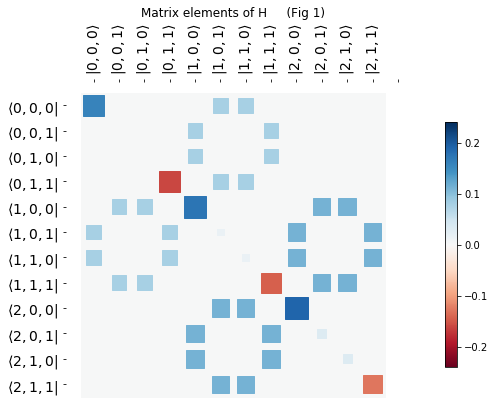

In [100]:
f, ax = hinton(H)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 1)");

The states are enumerated by $|n,m_1,m_2>$, where $n$ is the number of phonons and $m_i$ describes the state of the ith particle (0 is the higher energy `+` state, 1 is the lower energy `-` state).

The colour of each square of the Hinton diagram indicates the value of what we call the matrix elements of $H$. We write this as $<a,b,c |H| d,e,f>$, were a, b, c, d, e, f are the different numbers representing the 12 states. The matrix elements tell us how coupled the various states are to each other. In essence, the matrix elements tell us whether (and how quickly) one state can directly transition into another state.

For example, $<0,0,1 |H| 0,1,0>$ is a matrix element that describes excitation transfer from particle 1 to particle 2. We can see from Fig 1 that $<0,0,1 |H| 0,1,0> = 0$. We can therefore already tell, just by looking at the this plot, that there cannot be a direct transfer of an excitation from particle 1 to particle 2. There can however be excitation transfer mediated by $|1,0,0>$ and $|1,1,1>$ because both of these states couple to the initial ($| 0,0,1>$) and final ($| 0,1,0>$) states. 

Let's visually trace the path of an indirect excitation transfer from $| 0,0,1> \rightarrow |1,0,0> \rightarrow | 0,1,0>$.

                Matrix elements of H     (Fig 2)


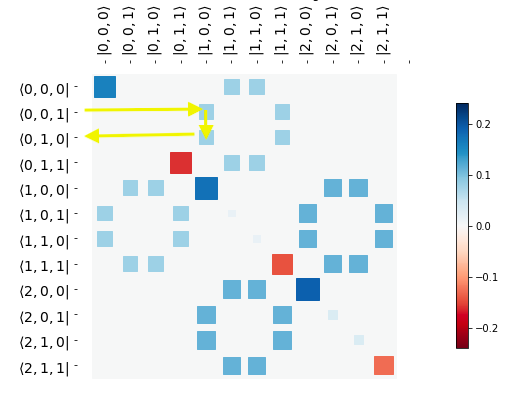

In [101]:
print("                Matrix elements of H     (Fig 2)")
Image(filename='indirect-transfer.png') 

## Understanding the state vector

We've seen that there are 12 possible states for the system. It can be helpful to represent the levels of the two state systems using ± notation rather than the 0,1 notation. This helps us remember which state has the higher/lower energy. The amplitude for the system at any time cant then be represented conceptually as:

$$
\begin{bmatrix}
 0,+,+    \\
 0,+,-   \\
 0,-,+   \\
 0,-,-   \\
 1,+,+    \\
 1,+,-   \\
 1,-,+   \\
 1,-,-   \\
 2,+,+    \\
 2,+,-   \\
 2,-,+   \\
 2,-,-   \\
\end{bmatrix}
$$

Where the first number, i.e. 0,1 or 2, is the number of phonons in the field, the first ± represents the state of the first two state system, and the second ± represents the state of the second two state system.



In order to make plots easier to understand, we'll create a function to label the simulation data according to the notation described above.

In [102]:
def states_to_df(states,times):
    
    data = {}
    for i in range(0,states[0].shape[0]):
        which_mode = divmod(i,4)
        if which_mode[1] == 0:
            two_state = "+ , +"
        elif which_mode[1] == 1:
            two_state = "+ , -"
        elif which_mode[1] == 2:
            two_state = "- , +"
        else:
            two_state = "- , -"
        data[str(which_mode[0])+" , "+two_state] = np.zeros(len(times),dtype="complex128")
    
    for i, state in enumerate(states):
        for j, psi in enumerate(state):
            which_mode = divmod(j,4)
            if which_mode[1] == 0:
                two_state = "+ , +"
            elif which_mode[1] == 1:
                two_state = "+ , -"
            elif which_mode[1] == 2:
                two_state = "- , +"
            else:
                two_state = "- , -"
            data[str(which_mode[0])+" , "+two_state][i] = psi[0][0]

    return pd.DataFrame(data=data, index=times)

## Simulation

We are going simulate the system described by $H$ above and see whether we can observe an indirect excitation transfer event from
$| 0,0,1> \rightarrow | 0,1,0> $. In the context of our tensor product notation, we will be looking for a change of state vector like this:
$$
 \begin{bmatrix}
 0    \\
 1   \\
 0   \\
 0   \\
 0    \\
 0   \\
 0   \\
 0   \\
 0    \\
 0   \\
 0   \\
 0   \\
\end{bmatrix} 
 \rightarrow
\begin{bmatrix}
 0    \\
 0   \\
 1   \\
 0   \\
 0    \\
 0   \\
 0   \\
 0   \\
 0    \\
 0   \\
 0   \\
 0   \\
\end{bmatrix} 
$$

(ignoring phase factors like $e^{i\phi}$).

We'll therefore need to set our initial state to be:

In [103]:
psi0 =  tensor(basis(M, 0), basis(2, 0), basis(2, 1))

i.e. we start off with no phonons, particle 1 in an excited (+) state and particle 2 in a lower energy (-) state.

Now we will solve the Schrödinger equation

In [118]:
times = np.linspace(0.0, 500.0, 10000) # simulation time
result = sesolve(H, psi0, times) 

In [119]:
df = states_to_df(result.states, times)

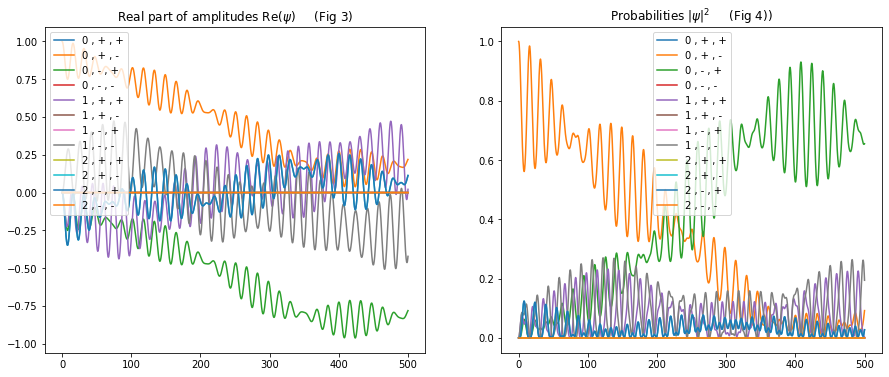

In [120]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df.plot(title="Real part of amplitudes Re($\psi$)     (Fig 3)", ax=axes[0]);
(df.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 4))", ax=axes[1]);

From Fig 4 we can see that system starts off with particle number 1 excited (orange line) and over time the excitation is transfered to particle number 2 (green line). This transfer appears to have been mediated by phonons with much less energy than the transition energy of the particle - recall that:

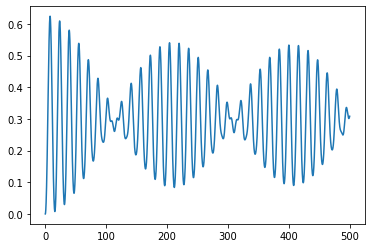

In [122]:
times = np.linspace(0.0, 500.0, 10000) # simulation time
result = sesolve(H, psi0, times, [a.dag()*a])
plt.plot(times,result.expect[0])

In [19]:
E_phonon

0.02

In [20]:
# transition enegry
2*A

0.2

We must however also recall that so far $g=A$ and so there is a strong coupling between the two state systems and the field. It might be more physically realistic to took at the case where the coupling to the field is a small perturbation. We will proceed in the same way as we did in `02-perturbing-a-two-state-system`, i.e. set $g/A = 0.01 \ll 1$

### Weak coupling

We start by only changing the coupling strength and keep everything else the same

In [21]:
A = 0.1
N = 10                 # number of phonon quanta needed to exite the particle
E_phonon = 2*A / N     # phonon energy
M =  3                 # M-1 is maximum number of phonons to simulate
g = 0.001              # weak coupling

a  = tensor(destroy(M), qeye(2), qeye(2))  # phonon destruction operator
sm1 = tensor(qeye(M), sigmam(), qeye(2))   # sigma_minus operator for two-state system number 1 
sz1 = tensor(qeye(M), sigmaz(),  qeye(2))  # sigma_z for two-state system number 1 
sm2 = tensor(qeye(M), qeye(2), sigmam())   # sigma_minus operator for two-state system number 2
sz2 = tensor(qeye(M), qeye(2), sigmaz())   # sigma_z for two-state system number 2

two_state_1    =    A*sz1
two_state_2    =    A*sz2
phonons        =    E_phonon*a.dag()*a
interaction_1  =    g*(a.dag() + a) * (sm1 + sm1.dag())
interaction_2  =    g*(a.dag() + a) * (sm2 + sm2.dag())


H = two_state_1 + two_state_2 + phonons + interaction_1 + interaction_2

In [22]:
psi0 =  tensor(basis(M, 0), basis(2, 0), basis(2, 1))
times = np.linspace(0.0, 5000.0, 1000) # simulation time
result = sesolve(H, psi0, times) 
df = states_to_df(result.states, times)

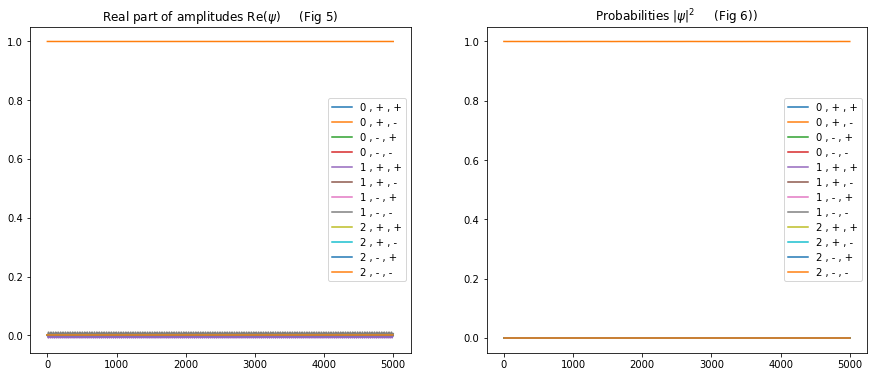

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df.plot(title="Real part of amplitudes Re($\psi$)     (Fig 5)", ax=axes[0]);
(df.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 6))", ax=axes[1]);
plt.legend(loc="right");

Fig 6 shows us that no excitation transfer takes place. This is perhaps not so surprising because the frequency of the phonons is not resonant with the two state transition, i.e. $E_{phonon}  \neq 2A \equiv \omega_0$. We learnt in the last tutorial that being off resonance by just 1% had a profound affect on the dynamics - full transfer from one state to another did not occur. In the above simulation $|E_{phonon}-\omega_0| / \omega_0 = 90\%$!

We are however working with a quantised field now, so maybe things aren't quite the same. Let's try running the simulation for a longer time.

In [24]:
psi0 =  tensor(basis(M, 0), basis(2, 0), basis(2, 1))
times = np.linspace(0.0, 5000000.0, 10000) # simulation time
result = sesolve(H, psi0, times) 
df = states_to_df(result.states, times)

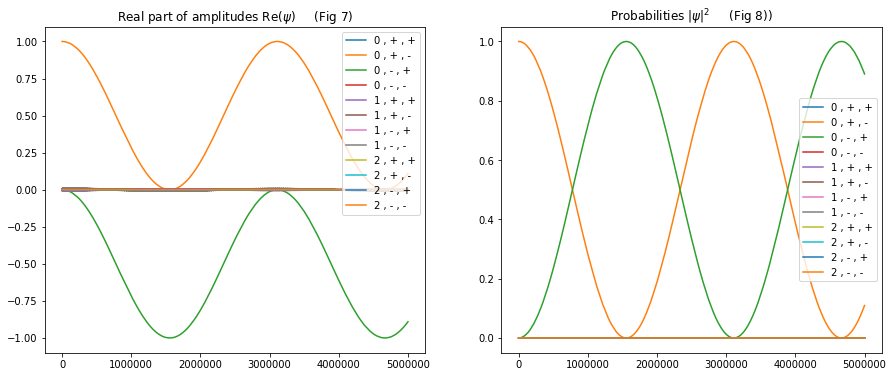

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df.plot(title="Real part of amplitudes Re($\psi$)     (Fig 7)", ax=axes[0]);
(df.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 8))", ax=axes[1]);
plt.legend(loc="right");

Fig 8 seems to show that, even when the coupling is very weak, we can still get what we might call non-resonant excitation transfer - it just takes a long time. This is unlike the case in the previous tutorial where an off-resonant perturbation from an external (non quantised field) was not able to cause a complete transition form one state to another (see Fig 9). Note that we can the same result if we allow 19 phonons to be present, i.e. $M=20$ (it just takes a long time to run so we don't do it here).

At first glance it might seem surprising that we don't see anything from states with 1 or 2 phonons. We must however recognise that the coupling of the 2 particles to the field, i.e. `g` is the same for both. Therefore any shifting of the two state energy levels due to the field (often referred to as `dressed` states/levels) will also be the same for both, i.e. there is no energy difference between +- and -+ and so no energetic need for a phonon to be involved in the transfer. Hagelstein discusses this in more depth in his paper [Excitation transfer in two two-level systems coupled to an oscillator](https://arxiv.org/abs/0803.1906v1) (in particular Eq 31, with g1=g2).

The Hagelstein paper above also gives an expression for the effective excitation transfer coupling between the two particles (his Eq 14). The coupling is proportional to the phonon energy. As we have seen in previous tutorials, rabi type oscillations occur at a freuency determined by the couping strength. We can therefore expect to find that by doubling our phonon energy the period of oscillation seen in Fig 8 will half. Let's see. 

To double the phonon energy we must change $N$ from 10 to 5.

In [90]:
A = 0.1
N = 5                 # number of phonon quanta needed to exite the particle
E_phonon = 2*A / N     # phonon energy
M =  3                 # M-1 is maximum number of phonons to simulate
g = 0.001              # weak coupling

a  = tensor(destroy(M), qeye(2), qeye(2))  # phonon destruction operator
sm1 = tensor(qeye(M), sigmam(), qeye(2))   # sigma_minus operator for two-state system number 1 
sz1 = tensor(qeye(M), sigmaz(),  qeye(2))  # sigma_z for two-state system number 1 
sm2 = tensor(qeye(M), qeye(2), sigmam())   # sigma_minus operator for two-state system number 2
sz2 = tensor(qeye(M), qeye(2), sigmaz())   # sigma_z for two-state system number 2

two_state_1    =    A*sz1
two_state_2    =    A*sz2
phonons        =    E_phonon*a.dag()*a
interaction_1  =    g*(a.dag() + a) * (sm1 + sm1.dag())
interaction_2  =    g*(a.dag() + a) * (sm2 + sm2.dag())


H = two_state_1 + two_state_2 + phonons + interaction_1 + interaction_2

In [91]:
psi0 =  tensor(basis(M, 0), basis(2, 0), basis(2, 1))
times = np.linspace(0.0, 5000000.0, 10000) # simulation time
result = sesolve(H, psi0, times) 
df = states_to_df(result.states, times)

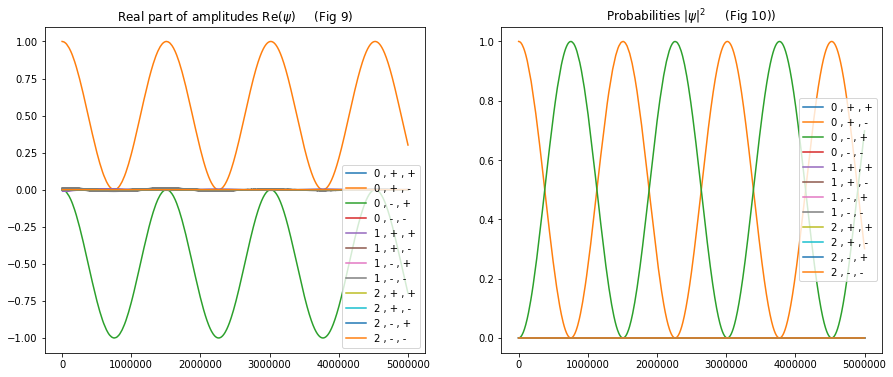

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df.plot(title="Real part of amplitudes Re($\psi$)     (Fig 9)", ax=axes[0]);
(df.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 10))", ax=axes[1]);
plt.legend(loc="right");

The period does indeed to appear to have halved.

In [93]:
from qutip.ipynbtools import plot_animation

In [87]:
A = 0.1
N = 5                 # number of phonon quanta needed to exite the particle
E_phonon = 2*A / N     # phonon energy
M =  20001                 # M-1 is maximum number of phonons to simulate
g = 0.001              # weak coupling

a  = tensor(destroy(M), qeye(2), qeye(2))  # phonon destruction operator
sm1 = tensor(qeye(M), sigmam(), qeye(2))   # sigma_minus operator for two-state system number 1 
sz1 = tensor(qeye(M), sigmaz(),  qeye(2))  # sigma_z for two-state system number 1 
sm2 = tensor(qeye(M), qeye(2), sigmam())   # sigma_minus operator for two-state system number 2
sz2 = tensor(qeye(M), qeye(2), sigmaz())   # sigma_z for two-state system number 2

two_state_1    =    A*sz1
two_state_2    =    A*sz2
phonons        =    E_phonon*a.dag()*a
interaction_1  =    g*(a.dag() + a) * (sm1 + sm1.dag())
interaction_2  =    g*(a.dag() + a) * (sm2 + sm2.dag())


H = two_state_1 + two_state_2 + phonons + interaction_1 + interaction_2

In [89]:
psi0 =  tensor(basis(M, 10001), basis(2, 0), basis(2, 1))
times = np.linspace(0.0, 50.0, 10000) # simulation time
result = sesolve(H, psi0, times) 



KeyboardInterrupt



In [ ]:
df = states_to_df(result.states, times)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
df.plot(title="Real part of amplitudes Re($\psi$)     (Fig 9)", ax=axes[0]);
(df.abs()**2).plot(title="Probabilities $|\psi|^2$     (Fig 10))", ax=axes[1]);
plt.legend(loc="right");

In [62]:
sigmam()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 0.]
 [1. 0.]]

In [76]:
A = 0.1
N = 11                 # number of phonon quanta needed to exite the particle
E_phonon = 2*A / N     # phonon energy
M =  20001                 # M-1 is maximum number of phonons to simulate
g = 0.001              # weak coupling

a  = tensor(destroy(M), qeye(2), qeye(2))  # phonon destruction operator
sm1 = tensor(qeye(M), sigmam(), qeye(2))   # sigma_minus operator for two-state system number 1 
sz1 = tensor(qeye(M), sigmaz(),  qeye(2))  # sigma_z for two-state system number 1 
sm2 = tensor(qeye(M), qeye(2), sigmam())   # sigma_minus operator for two-state system number 2
sz2 = tensor(qeye(M), qeye(2), sigmaz())   # sigma_z for two-state system number 2

two_state_1    =    A*sz1
two_state_2    =    A*(13/11)*sz2
phonons        =    E_phonon*a.dag()*a
interaction_1  =    g*(a.dag() + a) * (sm1 + sm1.dag())
interaction_2  =    g*(a.dag() + a) * (sm2 + sm2.dag())


H = two_state_1 + two_state_2 + phonons + interaction_1 + interaction_2

In [77]:
n = 10001 # n-1 is starting number of phonons

In [78]:
g_hagel = g*np.sqrt(n-1)/(2*A)
g_hagel

0.5

In [79]:
I= i*(a - a.dag())*tensor(qeye(M), sigmay(),  qeye(2))

In [80]:
for i in range(0,200):
    psi0 =  tensor(basis(M, n), basis(2, 0), basis(2, 1))
    psi1 =  tensor(basis(M, n+i), basis(2, 1), basis(2, 1))
    mat = I.matrix_element(psi0,psi1)
    print(mat/E_phonon)

0j
-1094609.4445280472j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
0j
